# Create test dataframe

In [ ]:
import pandas as pd
from time import sleep
from os import environ
from data.get_data import DataFactory
from config.config import ConfigFactory
from indicators.indicators import IndicatorFactory

if __name__ == "__main__":
    # Set environment variable
    environ["ENV"] = "development"
    # Set dataframe dict
    dfs = dict()
    # Set list of available exchanges, cryptocurrencies and tickers
    exchanges = {'Binance': {'BTCUSDT': ['5m']}}
    # Get configs
    configs = ConfigFactory.factory(environ).configs

    # For every exchange, ticker and timeframe in base get cryptocurrency data and write it to correspond dataframe
    for exchange in exchanges:
        exchange_api = DataFactory.factory(exchange)
        tickers = exchanges[exchange]
        for ticker in tickers:
            timeframes = tickers[ticker]
            for timeframe in timeframes:
                print(f'Cycle number is {i}, exchange is {exchange}, ticker is {ticker}, timeframe is {timeframe}')
                # If all cryptocurrencies signal stat is in dataframe dict - get it, else create new
                total_stat = dfs.get('total_stat', pd.DataFrame())
                # If cryptocurrency dataframe and it's signal stat is in dataframe dict - get it,
                # else - create the new ones
                df, stat = dfs.get(f'{ticker}_{timeframe}', (pd.DataFrame(), pd.Series()))
                # If dataframe is empty - get all available data to fill it,
                # else - just get necessary for update data
                if df.shape == (0, 0):
                    interval = configs['Interval']['creation_interval']
                else:
                    interval = configs['Interval']['update_interval']
                # Write data to the dataframe
                df = exchange_api.get_data(df, ticker, timeframe, interval)
                # Create indicator list
                indicator_list = configs['Indicator_list']
                indicators = list()
                for indicator in indicator_list:
                    indicators.append(IndicatorFactory.factory(indicator, configs))
                # Write indicators to dataframe
                df = exchange_api.add_indicator_data(df, indicators, ticker, timeframe)
                # Save dataframe to the disk
                df.to_pickle('df.pkl')
                # Update dataframe dict
                dfs[f'{ticker}_{timeframe}'] = df
                # Get signal
                stoch = SignalFactory().factory('STOCH')
                points = stoch.find_signal(df, ticker, timeframe)

## Find STOCH signals

In [18]:
def find_stoch_signal(df, lower_bound, upper_bound, ticker, timeframe):
    points = list()
    
    slowk, slowk_shift = df[f'{ticker}_{timeframe}_stoch_slowk'].values, df[f'{ticker}_{timeframe}_stoch_slowk'].shift(1)
    slowd, slowd_shift = df[f'{ticker}_{timeframe}_stoch_slowd'].values, df[f'{ticker}_{timeframe}_stoch_slowd'].shift(1)
    df['stoch_slowk_dir'] = (slowk-slowk_shift)/np.maximum(np.abs(slowk), np.abs(slowd_shift))
    df['stoch_slowd_dir'] = (slowd-slowd_shift)/np.maximum(np.abs(slowd), np.abs(slowd_shift))
    df['stoch_diff'] = slowk - slowd
    
    display(df.iloc[5:17])
    
    for i, row in df.iterrows():
        if i > 2 and row[f'{ticker}_{timeframe}_stoch_slowk'] <= lower_bound\
        and row[f'{ticker}_{timeframe}_stoch_slowd'] <= lower_bound:
                if row['stoch_diff'] > 0 and df.loc[i-1]['stoch_diff'] > 0 \
                   and df.loc[i-2]['stoch_diff'] > 0 and df.loc[i-3]['stoch_diff'] < 0 \
                   and df.loc[i-4]['stoch_diff'] < 0 and df.loc[i-5]['stoch_diff'] < 0 \
                   and row['stoch_slowk_dir'] > 0 and row['stoch_slowd_dir'] > 0:
                    points.append([row[f'{ticker}_{timeframe}_stoch_slowk'], i])
        elif i > 2 and row[f'{ticker}_{timeframe}_stoch_slowk'] >= upper_bound\
        and row[f'{ticker}_{timeframe}_stoch_slowd'] >= upper_bound:
                if row['stoch_diff'] < 0 and df.loc[i-1]['stoch_diff'] < 0 \
                   and df.loc[i-2]['stoch_diff'] < 0 and df.loc[i-3]['stoch_diff'] > 0 \
                   and df.loc[i-4]['stoch_diff'] > 0 and df.loc[i-5]['stoch_diff'] > 0 \
                   and row['stoch_slowk_dir'] < 0 and row['stoch_slowd_dir'] < 0:
                    points.append([row[f'{ticker}_{timeframe}_stoch_slowk'], i])
    return points
        
points = find_stoch_signal(cc_df, 20, 80, 'BTCUSDT', '5m')        

,BTCUSDT_5m_time,BTCUSDT_5m_open,BTCUSDT_5m_close,BTCUSDT_5m_high,BTCUSDT_5m_low,BTCUSDT_5m_volume,BTCUSDT_5m_rsi,BTCUSDT_5m_stoch_slowk,BTCUSDT_5m_stoch_slowd,stoch_slowk_dir,stoch_slowd_dir,stoch_diff
5,2022-08-14 07:25:00,24902.11,24884.87,24962.40,24843.60,1674.78145,81.394717,92.144714,88.122422,0.008376,0.057960,4.022292
6,2022-08-14 07:30:00,24886.00,24952.27,24973.39,24875.75,1225.98867,84.307433,91.396847,91.638162,-0.008183,0.038365,-0.241315
7,2022-08-14 07:35:00,24951.46,24953.25,24978.40,24915.56,1227.48271,84.345808,89.163050,90.901537,-0.024376,-0.008038,-1.738487
8,2022-08-14 07:40:00,24952.14,24975.32,24987.50,24922.00,964.73270,85.222241,94.907778,91.822558,0.060530,0.010030,3.085219
9,2022-08-14 07:45:00,24974.70,24989.36,24998.94,24941.67,937.31578,85.768124,95.882383,93.317737,0.010165,0.016022,2.564646
10,2022-08-14 07:50:00,24989.36,24927.81,25047.56,24903.37,2356.31472,73.031681,88.944774,93.244978,-0.074344,-0.000780,-4.300204
11,2022-08-14 07:55:00,24927.81,24873.32,24931.46,24817.15,1427.75955,63.974325,76.222428,87.016528,-0.136440,-0.066797,-10.794101
12,2022-08-14 08:00:00,24873.32,24810.88,24883.24,24778.00,1153.31384,55.482909,57.867061,74.344754,-0.210941,-0.145625,-16.477694
13,2022-08-14 08:05:00,24810.88,24772.31,24836.10,24728.32,1437.16540,50.981405,42.985924,59.025137,-0.200164,-0.206062,-16.039214
14,2022-08-14 08:10:00,24770.58,24796.31,24833.21,24753.90,918.96948,53.509034,30.881040,43.911341,-0.205080,-0.256057,-13.030302


## Plot STOCH values

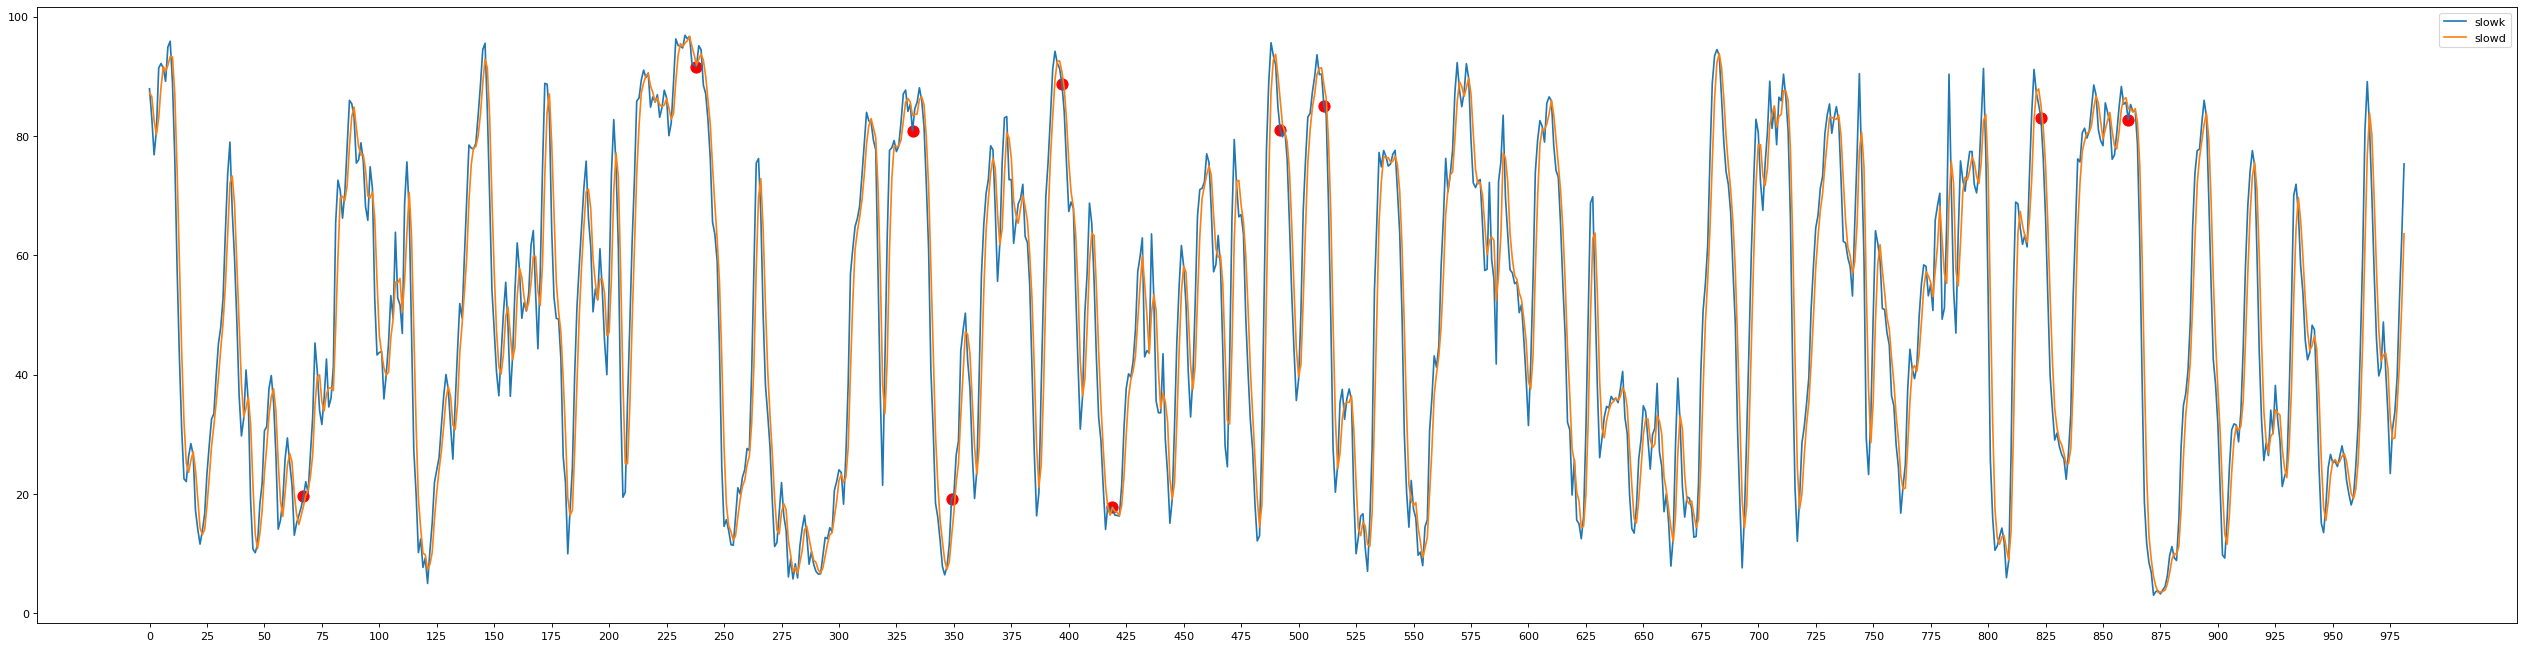

In [21]:
plt.figure(figsize=(40, 10), dpi=80)
ax = plt.axes()
ax.plot(df[f'BTCUSDT_{ticker}_stoch_slowk'])
ax.plot(df[f'BTCUSDT_{ticker}_stoch_slowd'])

ax.set_xticks(df.index)
plt.locator_params(axis='x', nbins=40)
for point in points:
    plt.scatter(point[1], point[0], s=100, color='red')
ax.legend(['slowk', 'slowd'])